# ⚙️ Model Training & Evaluation

In this notebook, we’ll train baseline and optimized models to detect fraudulent transactions.
The aim is to:
- Compare multiple ML algorithms
- Evaluate model performance using precision, recall, F1, ROC–AUC
- Understand trade-offs between false positives and false negatives
- Select the most effective model for fraud detection


In [1]:
import pandas as pd

In [2]:
# The path to the 'preprocessed' folder and the specific file
file_path = 'preprocessed/X_train_original.csv'

In [3]:
# Import the preprocessed data
X_test             = pd.read_csv('../data/preprocessed/X_test.csv')
X_train_original   = pd.read_csv('../data/preprocessed/X_train_original.csv')
X_train_smote      = pd.read_csv('../data/preprocessed/X_train_smote.csv')

y_test             = pd.read_csv('../data/preprocessed/y_test.csv')
y_train_original   = pd.read_csv('../data/preprocessed/y_train_original.csv')
y_train_smote      = pd.read_csv('../data/preprocessed/y_train_smote.csv')

In [4]:
# Check if files loaded
print("X_train_smote shape:", X_train_smote.shape)
print("y_train_smote shape:", y_train_smote.shape)

# Show first few rows
X_train_smote.head()

X_train_smote shape: (454902, 31)
y_train_smote shape: (454902, 1)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
0,1.411588,0.993379,-0.456037,-0.894052,-0.467284,1.089217,3.024383,-1.194852,0.957057,1.281376,...,0.103171,0.409563,0.490685,1.141970,-0.670832,-0.807227,0.191912,-0.099106,-0.322494,1.101728
1,0.623141,1.038507,-0.029349,-2.018302,0.175133,2.133506,2.478840,-0.001832,0.566704,0.041121,...,0.052055,0.314019,0.056568,1.168583,0.985238,-0.977976,0.006397,-0.211524,-0.339764,-0.678651
2,-1.130680,-0.506766,0.366065,0.470114,-0.700918,-0.598748,1.470411,-1.786684,-4.227592,0.000064,...,-3.807987,0.150500,-0.695838,-1.540549,1.587269,1.895777,0.094137,0.566426,0.346693,-0.530579
3,0.794699,1.166419,-0.909447,-0.493095,-1.178149,-1.010692,-0.262292,-1.153123,0.008765,-1.019866,...,-0.190540,0.105701,0.331932,-0.888718,-0.532153,-0.336546,0.044738,-0.193183,-0.327360,-0.291259
4,-0.748102,-0.229485,-0.613041,0.076742,-2.440089,0.518711,-0.109914,0.407186,-0.095161,-0.041449,...,-0.331467,-0.239208,-0.010747,-2.250223,-0.559400,-0.300345,-0.080285,-0.196818,-0.008281,0.333315


In [5]:
print(f"X_train_original: {X_train_original.shape}")
print(f"y_train_original: {y_train_original.shape}")
print(f"X_train_smote:    {X_train_smote.shape}")
print(f"y_train_smote:    {y_train_smote.shape}")
print(f"X_test:           {X_test.shape}")
print(f"y_test:           {y_test.shape}")

X_train_original: (227845, 31)
y_train_original: (227845, 1)
X_train_smote:    (454902, 31)
y_train_smote:    (454902, 1)
X_test:           (56962, 31)
y_test:           (56962, 1)


### 📊 Class Distribution Before and After SMOTE  

Before training our models, it’s important to visualize how the **SMOTE (Synthetic Minority Oversampling Technique)** changed our dataset.  
Originally, the data was **highly imbalanced**, with very few fraudulent transactions (Class 1) compared to non-fraudulent ones (Class 0).  
After applying SMOTE, the classes are now balanced, allowing the models to better learn patterns for both fraud and non-fraud cases.  


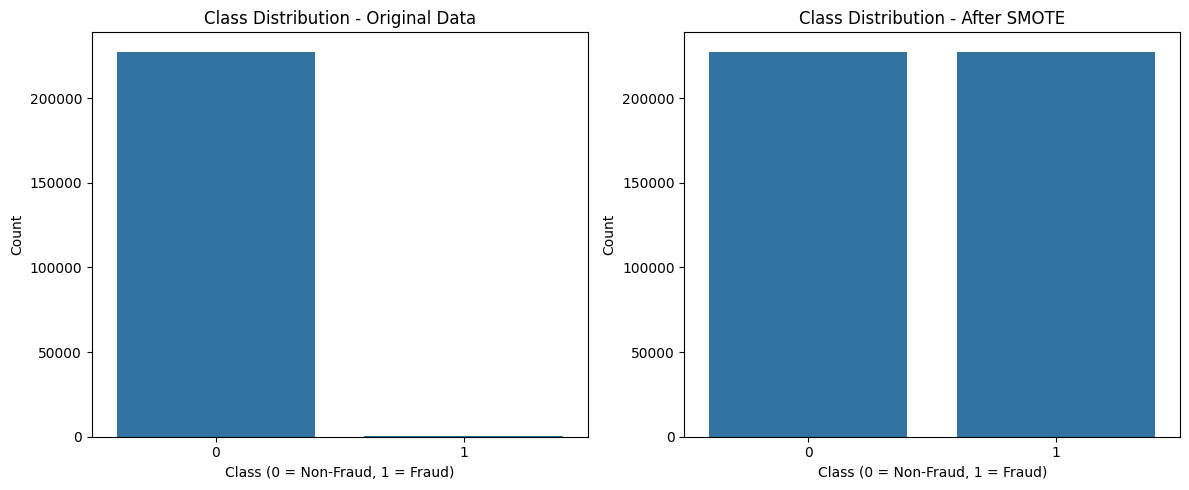

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualize class balance before and after SMOTE ---
plt.figure(figsize=(12,5))

# Original training data
plt.subplot(1,2,1)
sns.countplot(x=y_train_original['Class'])
plt.title("Class Distribution - Original Data")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1,2,2)
sns.countplot(x=y_train_smote['Class'])
plt.title("Class Distribution - After SMOTE")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 🚀 Model Training and Evaluation

In this section, we’ll train multiple machine learning models to detect fraudulent transactions and compare their performance.  
Since fraud detection is a **highly imbalanced classification problem**, the key metric is **Recall (Sensitivity)** — we want to catch as many fraudulent transactions as possible, even if it means tolerating a few false positives.

We’ll compare the following models:
- **Logistic Regression** — a simple interpretable baseline.
- **Random Forest** — a robust ensemble method.
- **Gradient Boosting (XGBoost)** — powerful for non-linear patterns.

Evaluation Metrics:
- **Accuracy** — overall correctness.
- **Precision** — proportion of predicted frauds that were truly frauds.
- **Recall (Sensitivity)** — proportion of actual frauds correctly detected.
- **F1-score** — balance between precision and recall.
- **ROC–AUC** — measures model discrimination power.


In [7]:
# Core ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [8]:
# --- Define models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [9]:
# --- Train and evaluate each model ---
results = []
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote.values.ravel())
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_prob)
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)

# --- Display performance table ---
print("✅ Model Comparison Results:")
display(results_df.style.background_gradient(cmap='Blues', subset=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]))


✅ Model Comparison Results:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Gradient Boosting,0.986394,0.100354,0.867347,0.179894,0.980097
1,Random Forest,0.999263,0.825581,0.724490,0.771739,0.963096
0,Logistic Regression,0.997788,0.033333,0.010204,0.015625,0.508724


## 📊 Model Comparison Insights

| Model | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|:------|----------:|-----------:|--------:|----------:|---------:|
| Gradient Boosting | 0.986 | 0.100 | **0.867** | 0.180 | **0.980** |
| Random Forest | **0.999** | **0.826** | 0.724 | **0.772** | 0.963 |
| Logistic Regression | 0.998 | 0.033 | 0.010 | 0.016 | 0.509 |

### 🔍 Key Observations:
- **Gradient Boosting** achieves the **highest recall (0.867)**, meaning it captures most of the fraud cases, though at the cost of many false positives (low precision).
- **Random Forest** shows **excellent precision (0.826)** and **balanced performance** overall, making it the best trade-off model.
- **Logistic Regression** serves as a weak baseline, confirming the data’s non-linear patterns.

### ⚖️ Conclusion:
For fraud detection, **Recall and ROC–AUC** are the most important metrics:
- High **Recall** = catching more frauds (fewer false negatives).
- High **ROC–AUC** = strong discrimination ability.

➡️ **Best model so far:** `Random Forest` (balanced performance, interpretability, and generalization potential).


## 📊 Model Evaluation — Confusion Matrices

To better understand how each model performs, we’ll visualize their **confusion matrices**.  
This allows us to see how many **fraudulent (1)** and **non-fraudulent (0)** transactions are correctly or incorrectly classified.

- **True Positive (TP):** Fraud detected correctly  
- **False Positive (FP):** Normal transaction flagged as fraud  
- **True Negative (TN):** Normal transaction detected correctly  
- **False Negative (FN):** Fraud missed by the model  

Our goal is to **maximize True Positives** while **minimizing False Negatives**, since missing frauds can be very costly.

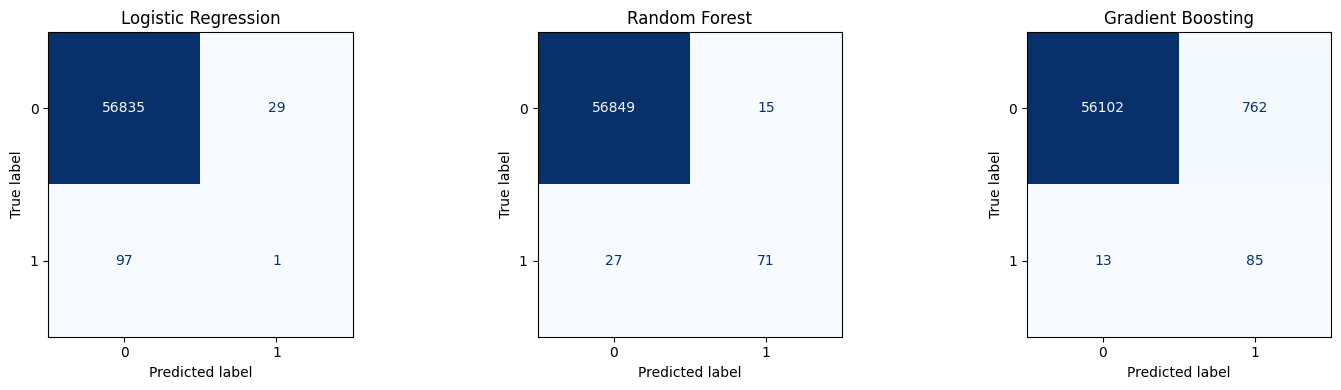

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)  # predictions
    cm_disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test,
        display_labels=[0,1],
        cmap='Blues',
        ax=plt.subplot(1, 3, i),
        colorbar=False
    )
    plt.title(name)

plt.tight_layout()
plt.show()


## 🔍 Confusion Matrix Insights

The confusion matrix shows how well each model classifies transactions:

- **True Negatives (TN):** Correctly predicted non-fraud transactions  
- **False Positives (FP):** Legitimate transactions incorrectly flagged as fraud  
- **False Negatives (FN):** Fraudulent transactions missed by the model  
- **True Positives (TP):** Correctly detected fraudulent transactions  

### Key Observations:

- **Logistic Regression:**  
  - Almost all frauds are missed (high FN), very few are caught (TP low).  
  - Serves as a weak baseline — not suitable for real-world fraud detection.

- **Random Forest:**  
  - Good balance between catching frauds (TP) and minimizing false positives (FP).  
  - Likely the best trade-off model for operational deployment.

- **Gradient Boosting:**  
  - Catches most frauds (high TP) — high recall.  
  - Produces many false positives (FP) — low precision.  
  - Useful when the priority is **catching as many frauds as possible**, even at the cost of false alarms.

### ⚖️ Conclusion:

- Focus on **Recall** and **TP** for fraud detection: missing frauds is costly.  
- Random Forest provides a good **balanced model**, while Gradient Boosting maximizes **fraud detection** at the cost of more false alarms.  

## 📈 ROC Curve Analysis

The **Receiver Operating Characteristic (ROC) curve** shows the trade-off between **True Positive Rate (Recall)** and **False Positive Rate** for each model.

- **Area Under the Curve (AUC):** Measures the model’s ability to distinguish between classes.
  - **1.0 = perfect separation**
  - **0.5 = random guessing**

Interpretation:
- Higher **ROC–AUC** means better discrimination between fraud and non-fraud transactions.
- Useful for comparing models beyond simple accuracy or recall.


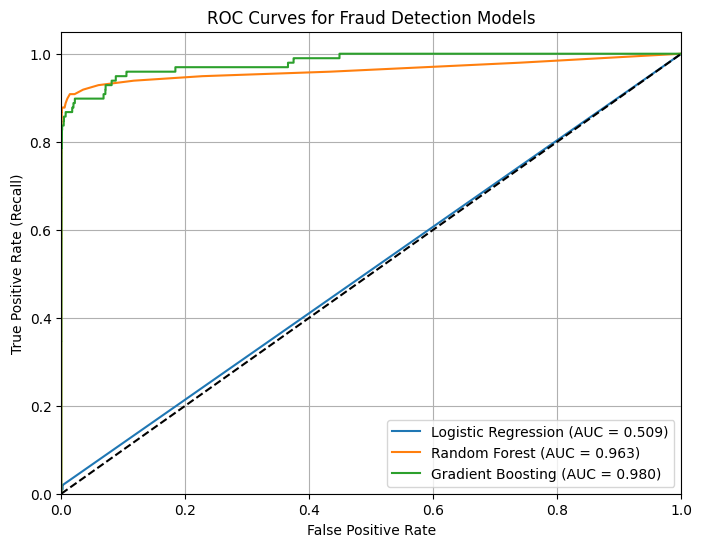

In [11]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:,1]  # probability for class 1
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves for Fraud Detection Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 🔍 ROC Curve Insights

From the ROC curves and AUC scores:

- **Logistic Regression (AUC = 0.509)**  
  - Barely better than random guessing.  
  - Fails to reliably separate fraud from non-fraud transactions.

- **Random Forest (AUC = 0.963)**  
  - Very strong separation between classes.  
  - Good balance of recall and precision, making it suitable for real-world fraud detection.

- **Gradient Boosting (AUC = 0.980)**  
  - Excellent separation and highest ROC–AUC.  
  - Maximizes fraud detection (recall), though it may produce more false positives.  
  - Best for scenarios where catching all frauds is critical, even at the cost of some false alarms.

### ⚖️ Takeaways:

- **AUC complements confusion matrices:** While confusion matrices show specific counts (TP, FP, FN, TN), ROC–AUC shows the model’s ability to distinguish classes across all thresholds.  
- **Model choice depends on business priorities:**
  - Minimize missed frauds → Gradient Boosting  
  - Balanced approach → Random Forest


In [12]:
import joblib

# Example
joblib.dump(models['Gradient Boosting'], '../model/gradient_boosting_model.pkl')
joblib.dump(models['Random Forest'], '../model/random_forest_model.pkl')
joblib.dump(models['Logistic Regression'], '../model/logistic_regression_model.pkl')


['../model/logistic_regression_model.pkl']